In [56]:
import itertools

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import lab.metrics

In [2]:
# Load the sizes from the configuration file
with open("../config/config.yaml", mode="r") as configfile:
    config = yaml.safe_load(configfile)
config

{'traces': {'monitored': '../removing-control-packets/results/filtered/monitored-traces.hdf',
  'unmonitored': '../removing-control-packets/results/filtered/unmonitored-traces.hdf'},
 'classifiers': ['dfnet', 'varcnn', 'p1fp', 'kfp'],
 'classifier_time': {'dfnet': 70, 'kfp': 10},
 'n_repetitions': 10,
 'quic_deployment_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [3]:
def load_results(classifiers: list, levels: list, repetitions: int):
    combinations = list(itertools.product(classifiers, levels, range(repetitions)))
    return pd.concat([
        pd.read_csv(f"../results/vary-deployment/{classifier}/predictions-{level:.1f}-{run:02d}.csv")
        for (classifier, level, run) in combinations
    ], keys=combinations, names=["classifier", "quic-frac", "run", "sample"])


# data = load_results(config["quic_deployment_levels"], config["n_repetitions"])
data = load_results(["kfp", "dfnet"], [0.1, 0.3, 0.5, 0.7, 0.9], config["n_repetitions"])
data

y_true        -1             0             1  \
classifier quic-frac run sample                                                 
kfp        0.1       0   0         -1.0  1.000000  0.000000e+00  0.000000e+00   
                         1         -1.0  1.000000  0.000000e+00  0.000000e+00   
                         2         92.0  1.000000  0.000000e+00  0.000000e+00   
                         3         -1.0  1.000000  0.000000e+00  0.000000e+00   
                         4         -1.0  1.000000  0.000000e+00  0.000000e+00   
...                                 ...       ...           ...           ...   
dfnet      0.9       9   5852      -1.0  1.000000  1.448462e-12  5.949203e-21   
                         5853      -1.0  0.999972  4.164266e-13  2.091794e-12   
                         5854      40.0  0.997842  7.472234e-09  1.425761e-13   
                         5855      56.0  0.000015  1.380849e-14  1.177815e-20   
                         5856      48.0  0.000400  4.749676e-09  4.248076e-12   

                                            2             3             4  \
classifier quic-frac run sample                                             
kfp        0.1       0   0       0.000000e+00  0.000000e+00  0.000000e+00   
                         1       0.000000e+00  0.000000e+00  0.000000e+00   
                         2       0.000000e+00  0.000000e+00  0.000000e+00   
                         3       0.000000e+00  0.000000e+00  0.000000e+00   
                         4       0.000000e+00  0.000000e+00  0.000000e+00   
...                                       ...           ...           ...   
dfnet      0.9       9   5852    2.979679e-12  1.450231e-15  1.565635e-08   
                         5853    1.383055e-13  7.406872e-10  3.896185e-10   
                         5854    1.160510e-08  1.201940e-09  4.226064e-08   
                         5855    2.204619e-17  1.110151e-19  3.237690e-11   
                         5856    1.155397e-10  3.670502e-13  1.483905e-10   

                                            5             6             7  \
classifier quic-frac run sample                                             
kfp        0.1       0   0       0.000000e+00  0.000000e+00  0.000000e+00   
                         1       0.000000e+00  0.000000e+00  0.000000e+00   
                         2       0.000000e+00  0.000000e+00  0.000000e+00   
                         3       0.000000e+00  0.000000e+00  0.000000e+00   
                         4       0.000000e+00  0.000000e+00  0.000000e+00   
...                                       ...           ...           ...   
dfnet      0.9       9   5852    1.815148e-18  4.133429e-19  5.441883e-13   
                         5853    9.068132e-10  1.426355e-11  3.969877e-11   
                         5854    1.335762e-08  2.226969e-04  1.594003e-10   
                         5855    1.611008e-14  1.216750e-12  5.873859e-18   
                         5856    8.287366e-09  1.001583e-14  2.314025e-09   

                                 ...            90            91  \
classifier quic-frac run sample  ...                               
kfp        0.1       0   0       ...  0.000000e+00  0.000000e+00   
                         1       ...  0.000000e+00  0.000000e+00   
                         2       ...  0.000000e+00  0.000000e+00   
                         3       ...  0.000000e+00  0.000000e+00   
                         4       ...  0.000000e+00  0.000000e+00   
...                              ...           ...           ...   
dfnet      0.9       9   5852    ...  3.335433e-20  7.359659e-15   
                         5853    ...  5.470294e-14  1.489172e-12   
                         5854    ...  7.792367e-12  6.669035e-11   
                         5855    ...  9.233495e-14  1.264741e-17   
                         5856    ...  1.878025e-11  1.949233e-09   

                                           92            93            94  \
classifier qu

In [4]:
def score(frame, ratio):
    classes = np.arange(-1, 100)
    class_cols = [str(class_) for class_ in classes]
    probabilities = frame.loc[:, class_cols].values
    
    y_true = frame["y_true"]
    y_pred = classes[np.argmax(probabilities, axis=1)]
    
    return pd.Series({
        "precision": lab.metrics.rprecision_score(y_true, y_pred, ratio=ratio),
        "recall": lab.metrics.recall_score(y_true, y_pred)
    })


plot_data = (data
             .groupby(["classifier", "quic-frac", "run"])
             .apply(score, ratio=20)
             .rename_axis("metric", axis=1)
             .stack()
             .rename("score")
             .transform(lambda x: x*100)
             .rename({"precision": "$\pi_{20}$", "recall": "Recall"})
             .reset_index())
plot_data

,classifier,quic-frac,run,metric,score
0,dfnet,0.1,0,$\pi_{20}$,64.238958
1,dfnet,0.1,0,Recall,94.300000
2,dfnet,0.1,1,$\pi_{20}$,53.361744
3,dfnet,0.1,1,Recall,94.800000
4,dfnet,0.1,2,$\pi_{20}$,61.902051
...,...,...,...,...,...
195,kfp,0.9,7,Recall,28.400000
196,kfp,0.9,8,$\pi_{20}$,70.731452
197,kfp,0.9,8,Recall,29.100000
198,kfp,0.9,9,$\pi_{20}$,83.596483


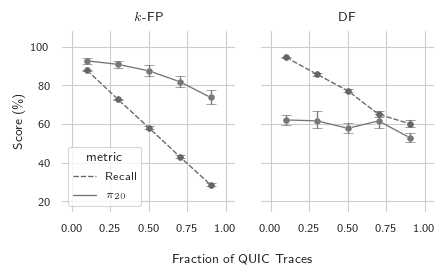

In [62]:
def plot_trend(data):
    data = data.set_index("classifier")
    plot_kws = dict(hue="metric", style="metric",# palette=['#666666', '#666666'],
                    marker="o", err_style="bars", err_kws={"capsize": 3}, 
                    seed=30002, hue_order=["Recall", "$\pi_{20}$"])
    
    with plt.style.context([
        "mpl-style/pets.mplstyle",  "mpl-style/white-grid.mplstyle", "mpl-style/line-plots.mplstyle",
        {"text.usetex": True}
    ]):
        figure, axes_list = plt.subplots(1, 2, sharey=True, figsize=(4, 2), 
                                         gridspec_kw=dict(wspace=.15), dpi=120, )
        (kfp_axes, dfnet_axes) = axes_list
        
        sns.lineplot(x="quic-frac", y="score", data=data.xs("dfnet"),
                     ax=dfnet_axes, **plot_kws)
        dfnet_axes.set_title("DF")
        
        sns.lineplot(x="quic-frac", y="score", data=data.xs("kfp"),
                     ax=kfp_axes, **plot_kws)
        kfp_axes.set_title("$k$-FP")
        
        for axes in (dfnet_axes, kfp_axes):
            axes.set_xlabel(None)
            axes.set_xticks([0, .25, .5, .75, 1])
            axes.set_yticks([20, 40, 60, 80, 100])
            axes.margins(.2, .2)
            axes.xaxis.set_major_formatter(StrMethodFormatter("{x:.02f}"))
            axes.yaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))
            
        axes_list[0].set_ylabel(r"Score (\%)")
        axes_list[1].get_legend().remove()
        
        figure.text(0.5, -0.09, "Fraction of QUIC Traces", ha='center') 

    sns.despine(left=True, bottom=True)
    
    return figure

figure = plot_trend(plot_data)
figure.savefig("../results/plots/vary-deployment.pgf", bbox_inches="tight", dpi=150)

In [6]:
summary = plot_data.groupby(["classifier", "quic-frac", "metric"])["score"].mean().unstack("metric")
summary

metric                $\pi_{20}$  Recall
classifier quic-frac                    
dfnet      0.1         62.161142   94.58
           0.3         61.704843   85.82
           0.5         57.874506   77.27
           0.7         61.647629   65.06
           0.9         53.052408   60.26
kfp        0.1         92.752583   87.88
           0.3         90.928744   72.85
           0.5         87.580766   58.19
           0.7         81.965663   43.20
           0.9         73.823448   28.64

In [7]:
print("k-fp change:", (summary.loc[("kfp", 0.1), :] - summary.loc[("kfp", 0.9), :]).to_dict(), "\n")
print("dfnet change:", (summary.loc[("dfnet", 0.1), :] - summary.loc[("dfnet", 0.9), :]).to_dict() )

k-fp change: {'$\\pi_{20}$': 18.92913465713771, 'Recall': 59.24000000000002} 

dfnet change: {'$\\pi_{20}$': 9.10873347041138, 'Recall': 34.32000000000001}
